In [31]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model,to_categorical
from tensorflow.keras.layers import Input, Dense, LSTM, Dropout, Embedding, add

In [32]:
BASE_DIR = '/home/kalpit/image_captioning'
WORKING_DIR = '/home/kalpit/image_captioning'

In [3]:
# Extracting Image Features

In [33]:
# loading the model
model = VGG16()
# restructuring the model
model = Model(inputs = model.inputs, outputs=model.layers[-2].output)
# summarising the model
print(model.summary())

Model: "model_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

In [ ]:
# Extracting features from image
# features will be a dictionary
features = {}
directory = os.path.join(BASE_DIR,'Images')
i =0
for image_name in tqdm(os.listdir(directory)):
    # load the image from file
    image_path = directory+'/'+ image_name
    # resizing the image
    image = load_img(image_path, target_size=(224,224))
    # converting image pixel to a numpy array
    image = img_to_array(image)
    # reshaping the image data for input to model
    # makes the array 1D for feding into the model
    image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    # preprocessing image for VGG
    image = preprocess_input(image)
    # extracting features
    feature = model.predict(image,verbose = 0)
    # getting the image ID, 0th index is image ID
    image_id = image_name.split('.')[0]
    # storing the feature
    features[image_id] = feature
    print(i)
    i = i+1
    

In [36]:
print(len(features))

8091


In [ ]:
# now lets store these features 
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pk2'), 'wb'))

In [35]:
# loading features from pickle
with open(os.path.join(WORKING_DIR, 'features.pk1'), 'rb') as f:
    features = pickle.load(f)

print(features['997722733_0cb5439472'])

[[0.         0.         0.95863956 ... 0.         0.         0.        ]]


In [37]:
# Now we will load the captions
with open(os.path.join(BASE_DIR,'captions.txt'), 'rb') as f:
    next(f)
    captions = f.read()

In [ ]:
# Now we will map images to caption with the help of image_id
mapping = {}

for line in tqdm(captions.decode('utf8').split("\n")):
    # split the image Id and caption
    token = line.split(',')
    # just for making sure that we dont have characters as captions of len less than 2
    if len(line)==2:
        continue
    image_id = token[0]
    caption = token[1:]
    # now the image_id also contains a jpg tag so we need to remove it
    image_id = image_id.split('.')[0]
    # converting the caption into string
    caption = " ".join(caption)
    # now a image can have multiple captions
    # so for that we need to have multiple copies
    # of images for multiple captions
    if image_id not in mapping:
        mapping[image_id] = []
    # storing the caption
    mapping[image_id].append(caption)
    

In [39]:
# preprocessing the captions 
def preprocessing(mapping):
    for key,captions in mapping.items():
        for i in range(len(captions)):
            caption = captions[i]
            # lowercasing every char
            caption = caption.lower()
            # deleting everything except characters a-z
            caption = caption.replace('[^A-Za-z]','')
            # deleting extra spaces
            caption = caption.replace("\s+", " ")
            # adding <start> and <end> token
            caption = 'startseq ' + " ".join([word for word in         caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

In [40]:
# before preprocessing
mapping['3727740053_3baa94ffcb']

['One man kicks another in the shoulder at a martial arts event .',
 'Two martial artists compete in a match .',
 'Two men are participating in a karate match .',
 'Two men in an oriental fighting contest .',
 'Two men in karate uniforms kicking each other .']

In [41]:
preprocessing(mapping)

In [42]:
# after preprocessing
mapping['3727740053_3baa94ffcb']

['startseq one man kicks another in the shoulder at martial arts event endseq',
 'startseq two martial artists compete in match endseq',
 'startseq two men are participating in karate match endseq',
 'startseq two men in an oriental fighting contest endseq',
 'startseq two men in karate uniforms kicking each other endseq']

In [43]:
# for tokenizing we would need all captions
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [44]:
# total no. of captions
len(all_captions)

40456

In [67]:
# lets tokenize all the captions
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index)+1

In [46]:
vocab_size

8485

In [47]:
# printing max len for padding
print(max(len(caption.split()) for caption in all_captions))

35


In [48]:
import torch
import tensorflow as tf

# If there's a GPU available...
if torch.cuda.is_available():    

    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 3 GPU(s) available.
We will use the GPU: GeForce RTX 2080 Ti


In [49]:
# train_test_split
from sklearn.model_selection import train_test_split
image_ids = list(mapping.keys())
train_ids, test_ids = train_test_split(image_ids, random_state=2010, test_size=0.1)

In [50]:
print(len(train_ids))

7282


In [51]:
# creating a dataloader for training in batches
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq],num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield [X1, X2], y
                X1, X2, y = list(), list(), list()
                n = 0    

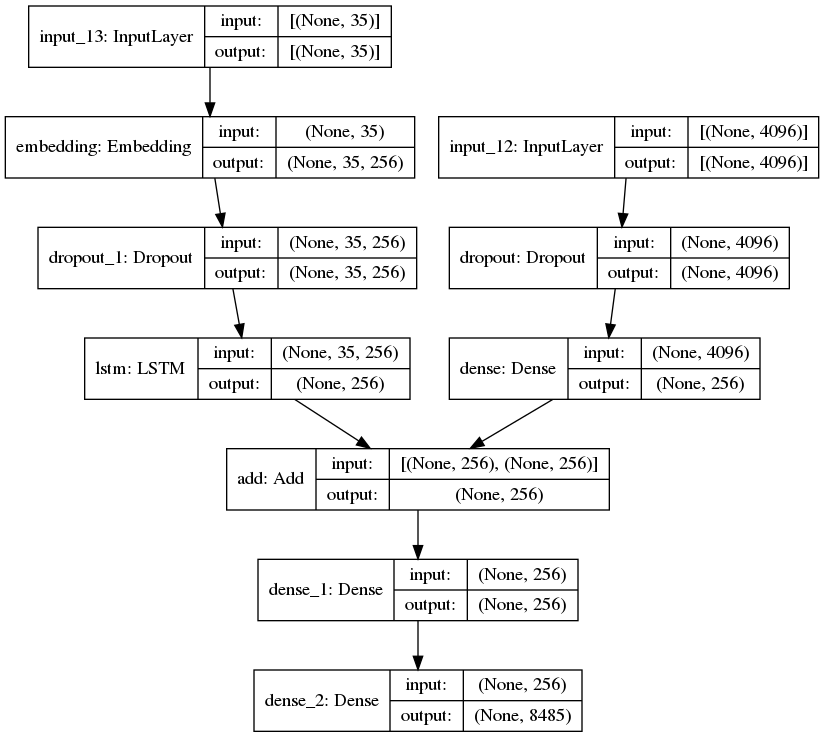

In [52]:
# encoder model
# image feature layers
inputs1 = Input(shape=(4096,))
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# sequence feature layers
inputs2 = Input(shape=(35,))
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# decoder model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# plot the model
plot_model(model, show_shapes=True)

In [ ]:
# train the model
epochs = 10
batch_size = 32
steps = len(train_ids) // batch_size

for i in range(epochs):
    # create data generator
    generator = data_generator(train_ids, mapping, features, tokenizer, 35, vocab_size, batch_size)
    # fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)


In [ ]:
model.save(WORKING_DIR+'/best_model.h5')

In [70]:
from keras.models import load_model

# Define the path to your saved model
model_path = WORKING_DIR + '/best_model.h5'

# Load the model
model = load_model(model_path)

In [26]:
print(model)

In [54]:
# now model returns the intger indice
# so we need to create a fucntion for
# getting word from its index
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [74]:
# generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break
    return in_text

In [ ]:
from nltk.translate.bleu_score import corpus_bleu
# validate with test data
actual, predicted = list(), list()

i = 0
for key in tqdm(test_ids):
    print(i)
    i = i+1
    # get actual caption
    captions = mapping[key]
    # predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, 35)
    # split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)
    # calcuate BLEU score

print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

In [42]:
print("BLEU-1: %f" % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
print("BLEU-2: %f" % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))

BLEU-1: 0.571243
BLEU-2: 0.342033


In [75]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # load the image
    # image_name = "1001773457_577c3a7d70.jpg"
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)
    # predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, 35)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

---------------------Actual---------------------
startseq black dog and spotted dog are fighting endseq
startseq black dog and tri-colored dog playing with each other on the road endseq
startseq black dog and white dog with brown spots are staring at each other in the street endseq
startseq two dogs of different breeds looking at each other on the road endseq
startseq two dogs on pavement moving toward each other endseq
--------------------Predicted--------------------
startseq two dogs play with each other on the sand endseq


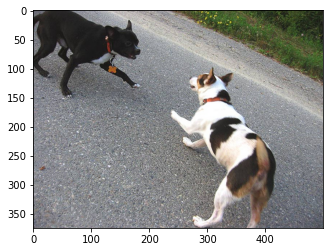

In [76]:
generate_caption("1001773457_577c3a7d70.jpg")

---------------------Actual---------------------
startseq little girl covered in paint sits in front of painted rainbow with her hands in bowl endseq
startseq little girl is sitting in front of large painted rainbow endseq
startseq small girl in the grass plays with fingerpaints in front of white canvas with rainbow on it endseq
startseq there is girl with pigtails sitting in front of rainbow painting endseq
startseq young girl with pigtails painting outside in the grass endseq
--------------------Predicted--------------------
startseq little girl is playing on the sidewalk endseq


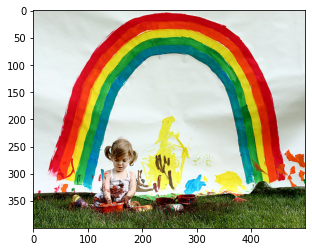

In [77]:
generate_caption("1002674143_1b742ab4b8.jpg")

---------------------Actual---------------------
startseq man in hat is displaying pictures next to skier in blue hat endseq
startseq man skis past another man displaying paintings in the snow endseq
startseq person wearing skis looking at framed pictures set up in the snow endseq
startseq skier looks at framed pictures in the snow next to trees endseq
startseq man on skis looking at artwork for sale in the snow endseq
--------------------Predicted--------------------
startseq skier is skiing through the snow endseq


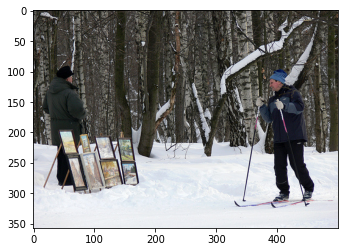

In [78]:
generate_caption("101669240_b2d3e7f17b.jpg")

---------------------Actual---------------------
startseq man in pink shirt climbs rock face endseq
startseq man is rock climbing high in the air endseq
startseq person in red shirt climbing up rock face covered in assist handles endseq
startseq rock climber in red shirt endseq
startseq rock climber practices on rock climbing wall endseq
--------------------Predicted--------------------
startseq man in red shirt is climbing rock wall endseq


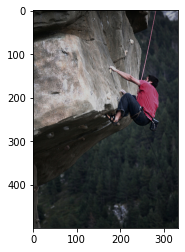

In [79]:
generate_caption('997722733_0cb5439472.jpg')

In [71]:
def predict_new(image_path):
    image = load_img(image_path, target_size=(224,224))
    # converting image pixel to a numpy array
    image = img_to_array(image)
    # reshaping the image data for input to model
    # makes the array 1D for feding into the model
    image = image.reshape(1,image.shape[0],image.shape[1],image.shape[2])
    # preprocessing image for VGG
    image = preprocess_input(image)
    # extracting features
    
    # loading the model
    model1 = VGG16()
    # restructuring the model
    model1 = Model(inputs = model1.inputs, outputs=model1.layers[-2].output)
    # summarising the model
#     print(model1.summary())
    feature = model1.predict(image,verbose = 0)

    image = Image.open(image_path)
    # predict the caption
#     tokenizer = Tokenizer()
    y_pred = predict_caption(model, feature, tokenizer, 35)
    print('--------------------Predicted--------------------')
    print(y_pred)
    plt.imshow(image)

--------------------Predicted--------------------
startseq black dog is running in the grass endseq


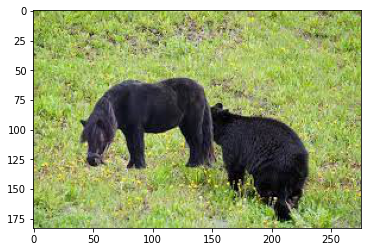

In [84]:
predict_new("new_image/images.jpeg")

--------------------Predicted--------------------
startseq surfer rides wave endseq


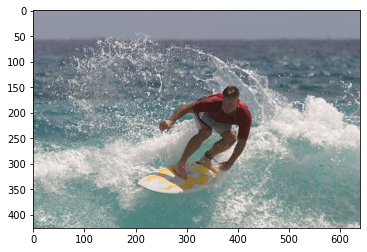

In [85]:
predict_new("new_image/surf.jpg")

--------------------Predicted--------------------
startseq man in blue shirt is running down the ground endseq


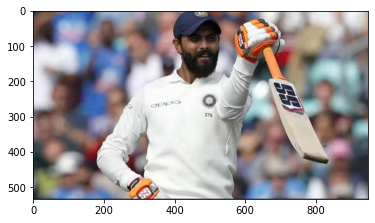

In [86]:
predict_new("new_image/jadeja.jpeg")

--------------------Predicted--------------------
startseq dog running through the grass endseq


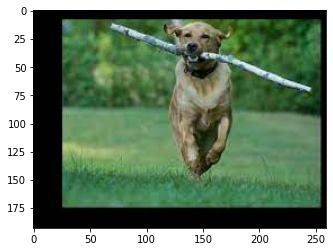

In [87]:
predict_new("new_image/doggo.jpeg")

--------------------Predicted--------------------
startseq bird is flying over the bloom of plants endseq


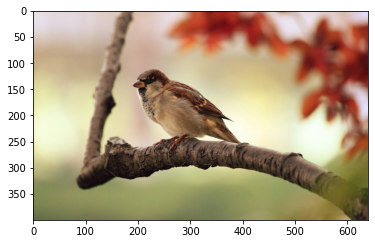

In [90]:
predict_new("new_image/HouseSparrow.jpg")